Code Ref used - https://debuggercafe.com/transfer-learning-using-efficientnet-pytorch/

In [ ]:
import pandas as pd
import numpy as np

In [1]:
import torch
import pathlib
import random
import cv2
import gc
import sys
import matplotlib.pyplot as plt
import os
import shutil

import sklearn.model_selection as ms
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torchvision.models as models
import torch.optim as optim
import time
from torch import nn
from tqdm.auto import tqdm

%matplotlib inline
device = torch.device("cpu")
print(f'Using {device}')

Using cpu


In [8]:
base_path = "C:/Users/anush/OneDrive/Documents/Sem3/AI in Health Technology/Project/"
traincsv = base_path + "data_asDownloaded/train.csv"
valcsv = base_path + "/valid.csv"
testcsv = base_path + "/test.csv"

trainimagespath = base_path + "data_asDownloaded/train_images/train_images/"
valimagespath = base_path + "/val_images/val_images/"
testimagespath = base_path + "/test_images/test_images/"

## Dataset

In [50]:
#Instructions for easy dataset management:
# Rename val csv to valid.csv
# Rename val_images folder to valid_images (for easy copying into class folders)
# Rename train_1.csv to train.csv (for easy copying into class folders)

In [49]:
os.makedirs('data', exist_ok=True)
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/test', exist_ok=True)
os.makedirs('data/valid', exist_ok=True)

subset = ['train', 'test', 'valid']
for s in subset:
    os.makedirs('data/' + s, exist_ok=True)
    for i in range(5):
        os.makedirs('data/' + s + '/'+str(i), exist_ok=True)

In [54]:
for s in subset:
    data = pd.read_csv(base_path + "/data_asDownloaded/" + s + ".csv")
    for idx, row in data.iterrows():
        category = row['diagnosis']
        shutil.copy(base_path + "/data_asDownloaded" + "/" + s + "_images/" + s + "_images/" + row['id_code'] + ".png",
                    base_path + "/data/" + s + "/" + str(row['diagnosis']) + "/" + row['id_code'] + ".png")

In [26]:
def get_train_transform():
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), #maybe remove
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    return train_transform


def get_valid_transform():
    valid_transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    return valid_transform

def normalize_transform():
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    return normalize

In [27]:
def get_datasets():
    dataset_train = datasets.ImageFolder(
        base_path+"/data/train", 
        transform=(get_train_transform(pretrained=True))
    )
    dataset_val = datasets.ImageFolder(
        base_path+"/data/valid", 
        transform=(get_valid_transform(pretrained=True))
    )
    dataset_test = datasets.ImageFolder(
        base_path+"/data/test", 
        transform=(get_valid_transform(pretrained=True))
    )
    return dataset_train, dataset_val, dataset_test, dataset_train.classes


def get_data_loaders(dataset_train, dataset_valid, dataset_test, BATCH_SIZE=8):
    train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, valid_loader, test_loader

In [28]:
dataset_train, dataset_valid, dataset_test, dataset_classes = get_datasets(True)

In [29]:
dataset_train

Dataset ImageFolder
    Number of datapoints: 2930
    Root location: C:/Users/anush/OneDrive/Documents/Sem3/AI in Health Technology/Project//data/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
               RandomAdjustSharpness(sharpness_factor=2,p=0.5)
               Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [30]:
# Load the training and validation data loaders.
train_loader, valid_loader, test_loader = get_data_loaders(dataset_train, dataset_valid, dataset_test)

In [31]:
train_loader

In [32]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 2930
    Root location: C:/Users/anush/OneDrive/Documents/Sem3/AI in Health Technology/Project//data/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
               RandomAdjustSharpness(sharpness_factor=2,p=0.5)
               Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## Model

In [54]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, pretrained):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
    plt.plot(valid_acc, color='blue', linestyle='-', label='validataion accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(base_path + f"/outputs/accuracy_pretrained_{pretrained}.png")
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
    plt.plot(valid_loss, color='red', linestyle='-', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(base_path + f"/outputs/loss_pretrained_{pretrained}.png")

In [40]:
model = models.efficientnet_b0(pretrained=True)

In [41]:
#For no finetuning-> Freezing model weights
for params in model.parameters():
    params.requires_grad = False

In [42]:
# Change the final classification head.
num_classes = 5
model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)

In [43]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [77]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

4,013,953 total parameters.
6,405 training parameters.


In [44]:
# Optimizer:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Loss function:
criterion = nn.CrossEntropyLoss()

In [49]:
def train(model, trainloader, optimizer, criterion, epochNum):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
        
    torch.save(model, base_path+f"/b0_linear/model_checkpoint_{epochNum}.pt")
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [50]:
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

[INFO]: Epoch 1 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 1.145, training acc: 61.877
Validation loss: 1.007, validation acc: 66.393
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.964, training acc: 67.406
Validation loss: 0.890, validation acc: 69.126
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.904, training acc: 68.430
Validation loss: 0.830, validation acc: 68.852
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.860, training acc: 69.249
Validation loss: 0.796, validation acc: 72.678
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.820, training acc: 70.273
Validation loss: 0.764, validation acc: 72.951
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.807, training acc: 70.648
Validation loss: 0.753, validation acc: 71.311
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.775, training acc: 71.741
Validation loss: 0.725, validation acc: 74.317
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.766, training acc: 72.048
Validation loss: 0.703, validation acc: 74.317
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.749, training acc: 72.560
Validation loss: 0.702, validation acc: 72.404
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.754, training acc: 72.594
Validation loss: 0.710, validation acc: 73.770
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.754, training acc: 72.969
Validation loss: 0.676, validation acc: 72.678
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.733, training acc: 72.833
Validation loss: 0.667, validation acc: 76.503
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.722, training acc: 74.369
Validation loss: 0.662, validation acc: 74.590
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.730, training acc: 72.116
Validation loss: 0.654, validation acc: 74.863
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.700, training acc: 74.915
Validation loss: 0.647, validation acc: 74.863
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.705, training acc: 74.369
Validation loss: 0.638, validation acc: 76.230
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.714, training acc: 73.584
Validation loss: 0.640, validation acc: 76.776
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.691, training acc: 75.256
Validation loss: 0.636, validation acc: 75.956
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.692, training acc: 75.461
Validation loss: 0.612, validation acc: 77.049
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training


  0%|          | 0/367 [00:00<?, ?it/s]

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Training loss: 0.690, training acc: 75.085
Validation loss: 0.614, validation acc: 77.049
--------------------------------------------------


FileNotFoundError: [Errno 2] No such file or directory: '../outputs/accuracy_pretrained_True.png'

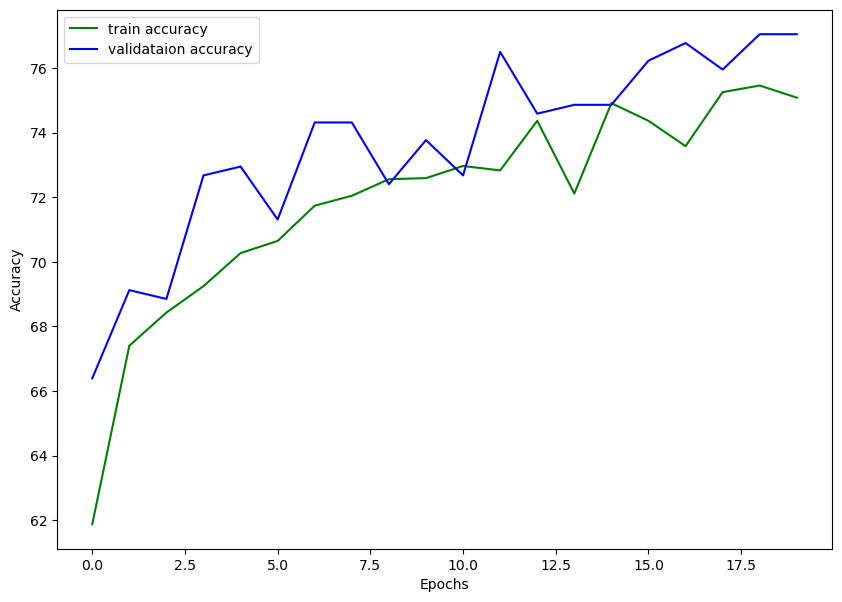

In [52]:
epochs = 20
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion, epoch)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(5)

save_plots(train_acc, valid_acc, train_loss, valid_loss, "True")
print('TRAINING COMPLETE')

TRAINING COMPLETE


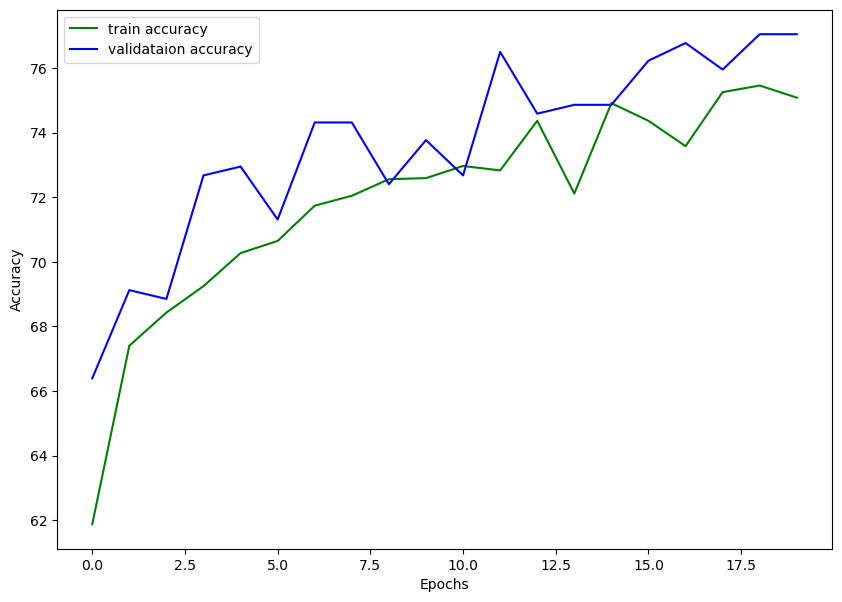

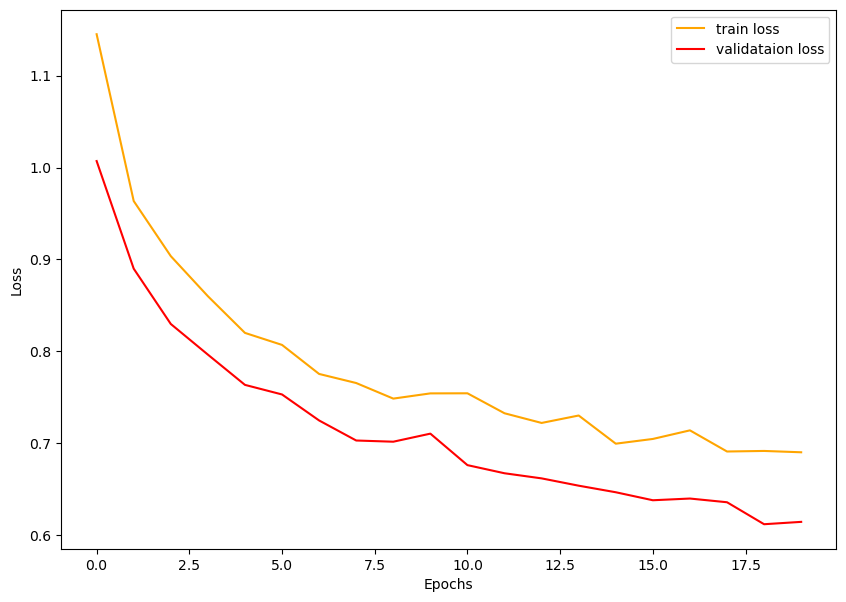

In [55]:
save_plots(train_acc, valid_acc, train_loss, valid_loss, "True")
print('TRAINING COMPLETE')

Testing on test set: unseen test set

output: loss, accuracy

In [57]:
validate(model, test_loader, criterion)

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

(0.5958117387945885, 77.59562841530054)

In [58]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

In [61]:
def validate_balancedAcc(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    list_preds = []
    list_labels = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            list_preds.append(preds)
            list_labels.append(labels)
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    #balanced_acc = balanced_accuracy_score(y_true=list_labels, y_pred=list_preds)
    #cohen = cohen_kappa_score(list_labels, list_preds, labels=[0,1,2,3,4])
    return epoch_loss, epoch_acc, list_labels, list_preds

In [62]:
_, _, true, pred = validate_balancedAcc(model, test_loader, criterion)

Validation


  0%|          | 0/46 [00:00<?, ?it/s]

In [70]:
list_true = []
for i in range(len(true)):
    for j in range(0, true[i].shape[0]):
        list_true.append(int(true[i][j]))
        
list_pred = []
for i in range(len(pred)):
    for j in range(0, pred[i].shape[0]):
        list_pred.append(int(pred[i][j]))

In [71]:
balanced_acc = balanced_accuracy_score(list_true, list_pred)

In [72]:
balanced_acc

0.5196505917626734

In [75]:
def validate_2(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    list_preds = []
    list_labels = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            list_preds.append(preds)
            list_labels.append(labels)
            
            
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    
    #for balanced accuracy
    list_true = []
    for i in range(len(list_labels)):
        for j in range(0, list_labels[i].shape[0]):
            list_true.append(int(list_labels[i][j]))

    list_pred = []
    for i in range(len(list_preds)):
        for j in range(0, list_preds[i].shape[0]):
            list_pred.append(int(list_preds[i][j]))
            
    balanced_acc = balanced_accuracy_score(list_true, list_pred)
    return epoch_loss, epoch_acc, balanced_acc

In [76]:
for i in range(0, 20):
    print(f"[INFO]: Model {i} from Epoch {i+1}")
    PATH_1 = base_path+f"/b0_linear/model_checkpoint_{i}.pt"
    model_1 = torch.load(PATH_1, weights_only=False)
    valid_epoch_loss, valid_epoch_acc, valid_bacc = validate_2(model_1, valid_loader, criterion)
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}, validation BACC: {valid_bacc:.3f}")
    print('-'*50)
    time.sleep(5)

[INFO]: Model 0 from Epoch 1
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 1.007, validation acc: 66.393, validation BACC: 0.345
--------------------------------------------------
[INFO]: Model 1 from Epoch 2
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.890, validation acc: 69.126, validation BACC: 0.364
--------------------------------------------------
[INFO]: Model 2 from Epoch 3
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.830, validation acc: 68.852, validation BACC: 0.371
--------------------------------------------------
[INFO]: Model 3 from Epoch 4
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.796, validation acc: 72.678, validation BACC: 0.419
--------------------------------------------------
[INFO]: Model 4 from Epoch 5
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.764, validation acc: 72.951, validation BACC: 0.434
--------------------------------------------------
[INFO]: Model 5 from Epoch 6
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.753, validation acc: 71.311, validation BACC: 0.439
--------------------------------------------------
[INFO]: Model 6 from Epoch 7
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.725, validation acc: 74.317, validation BACC: 0.455
--------------------------------------------------
[INFO]: Model 7 from Epoch 8
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.703, validation acc: 74.317, validation BACC: 0.464
--------------------------------------------------
[INFO]: Model 8 from Epoch 9
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.702, validation acc: 72.404, validation BACC: 0.455
--------------------------------------------------
[INFO]: Model 9 from Epoch 10
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.710, validation acc: 73.770, validation BACC: 0.516
--------------------------------------------------
[INFO]: Model 10 from Epoch 11
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.676, validation acc: 72.678, validation BACC: 0.464
--------------------------------------------------
[INFO]: Model 11 from Epoch 12
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.667, validation acc: 76.503, validation BACC: 0.556
--------------------------------------------------
[INFO]: Model 12 from Epoch 13
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.662, validation acc: 74.590, validation BACC: 0.495
--------------------------------------------------
[INFO]: Model 13 from Epoch 14
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.654, validation acc: 74.863, validation BACC: 0.503
--------------------------------------------------
[INFO]: Model 14 from Epoch 15
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.647, validation acc: 74.863, validation BACC: 0.511
--------------------------------------------------
[INFO]: Model 15 from Epoch 16
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.638, validation acc: 76.230, validation BACC: 0.523
--------------------------------------------------
[INFO]: Model 16 from Epoch 17
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.640, validation acc: 76.776, validation BACC: 0.554
--------------------------------------------------
[INFO]: Model 17 from Epoch 18
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.636, validation acc: 75.956, validation BACC: 0.559
--------------------------------------------------
[INFO]: Model 18 from Epoch 19
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.612, validation acc: 77.049, validation BACC: 0.541
--------------------------------------------------
[INFO]: Model 19 from Epoch 20
Validation


  0%|          | 0/46 [00:00<?, ?it/s]

Validation loss: 0.614, validation acc: 77.049, validation BACC: 0.552
--------------------------------------------------
